In [16]:
library(caret)
library(dplyr)
library(cluster)
library(sampling)
library(VIM)
library(mice)
library(stats)
library(ModelMetrics)
library(randomForest)
library(forecast)
library(Rcpp) 
library(RSNNS)
library(MASS)
library(grid)
library(neuralnet)
library(FNN)

In [33]:
setwd("~/Documents/INFO7390 Data Science/case study 2")
ts <- read.csv("./training set/loandata_2.csv")

In [34]:
set.seed(1222)
sub<-sample(1:nrow(ts),round(nrow(ts)*1/100))
length(sub)
data_train<-ts[sub,]

[1] 15241

In [35]:
ds5 <- daisy(data_train)

In [36]:
c <- clara(as.matrix(ds5),5)
rm(ds5)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2874065,153.5,8273852,441.9,8273852,441.9
Vcells,310996973,2372.8,1396300268,10653.0,1706591936,13020.3


In [37]:
data_train[,81] <- as.matrix(c$clustering)

# Pre

In [38]:
f <- read.csv("./training set/features.csv")
co <- c(names(f),'int_rate','V81')
print(co)
x <- data_train[,co]
head(x)

 [1] "annual_inc"          "dti"                 "last_pymnt_amnt"    
 [4] "mths_since_rcnt_il"  "all_util"            "total_rev_hi_lim"   
 [7] "inq_last_12m"        "percent_bc_gt_75"    "term"               
[10] "grade"               "sub_grade"           "verification_status"
[13] "revol_util"          "int_rate"            "V81"                


,annual_inc,dti,last_pymnt_amnt,mths_since_rcnt_il,all_util,total_rev_hi_lim,inq_last_12m,percent_bc_gt_75,term,grade,sub_grade,verification_status,revol_util,int_rate,V81
979081,120500,2.94,876.00,70,29,72800,1,25.0,36 months,A,A5,Not Verified,28.6%,7.89%,1
858344,48000,20.10,340.13,NA,NA,23600,NA,62.5,36 months,C,C3,Not Verified,32.5%,13.66%,2
337430,180000,11.50,14185.45,NA,NA,28745,NA,100.0,60 months,C,C3,Verified,95.2%,13.98%,3
889960,58000,9.83,471.65,25,83,22700,2,100.0,36 months,C,C2,Source Verified,82.6%,12.99%,4
425278,65000,21.57,5361.58,NA,NA,22250,NA,100.0,36 months,A,A4,Source Verified,56%,7.90%,2
1142026,75000,13.52,523.75,13,61,25300,0,50.0,36 months,B,B4,Verified,57.1%,10.99%,4


In [39]:
# Missing value
x[x == ""] <- NA
x <- x[complete.cases(x),]
# Pre
x[,9:12] <- data.frame(apply(x[,9:12], 2, as.factor))
# Change factor into numeric
for (i in 9:12)
    x[,i] <- as.numeric(x[,i])
x[,13:14] <- data.frame(lapply(x[,13:14], function(x) as.numeric(sub("%", "", x))/100))
# Outliers
out_inc <- which(x[,1] > 1e6)
x[out_inc,1] <- NA
out_dti <- which((x[,2]>20)|(x[,2]<0))
x[out_dti,2] <- NA
out_pay <- which(x[,3]>20000)
x[out_pay,3] <- NA
out_mon <- which(x[,4]>24)
x[out_mon,4] <- NA
out_rev <- which(x[,6]>100000)
x[out_rev,6] <- NA
x <- x[complete.cases(x),]

In [40]:
rm(ts)
rm(out_inc)
rm(out_dti)
rm(out_pay)
rm(out_mon)
rm(out_rev)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2874144,153.5,8273852,441.9,8273852,441.9
Vcells,240136847,1832.1,1117040214,8522.4,1706591936,13020.3


In [41]:
f <- as.formula(paste("int_rate ~", paste(names(x[,-c(14:15)]), collapse = " + ")))

[1] 1
[1] "************ Linear Regression ************"

Call:
lm(formula = f, data = a.train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.028212 -0.004444 -0.001042  0.003997  0.034833 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          4.160e-02  3.898e-03  10.671  < 2e-16 ***
annual_inc          -5.795e-09  6.234e-09  -0.930  0.35331    
dti                  2.186e-06  1.199e-04   0.018  0.98546    
last_pymnt_amnt     -3.655e-07  5.700e-07  -0.641  0.52182    
mths_since_rcnt_il   4.707e-05  7.755e-05   0.607  0.54428    
all_util             1.774e-06  3.424e-05   0.052  0.95872    
total_rev_hi_lim     6.988e-08  2.483e-08   2.814  0.00519 ** 
inq_last_12m        -3.194e-04  2.203e-04  -1.450  0.14801    
percent_bc_gt_75    -6.038e-06  1.946e-05  -0.310  0.75660    
term                -2.720e-03  1.075e-03  -2.531  0.01185 *  
grade                2.151e-03  1.630e-03   1.319  0.18808    
sub_grade           

Warning message in temp[1] <- a.lm:
“被替换的项目不是替换值长度的倍数”

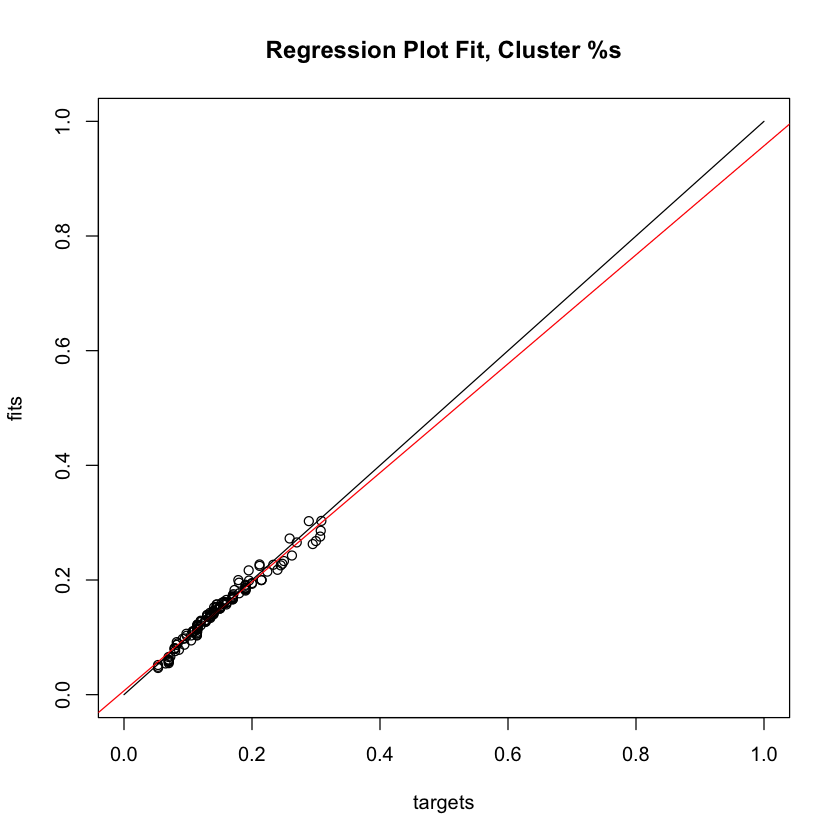

[1] 1
[1] "************ Random Forest ************"


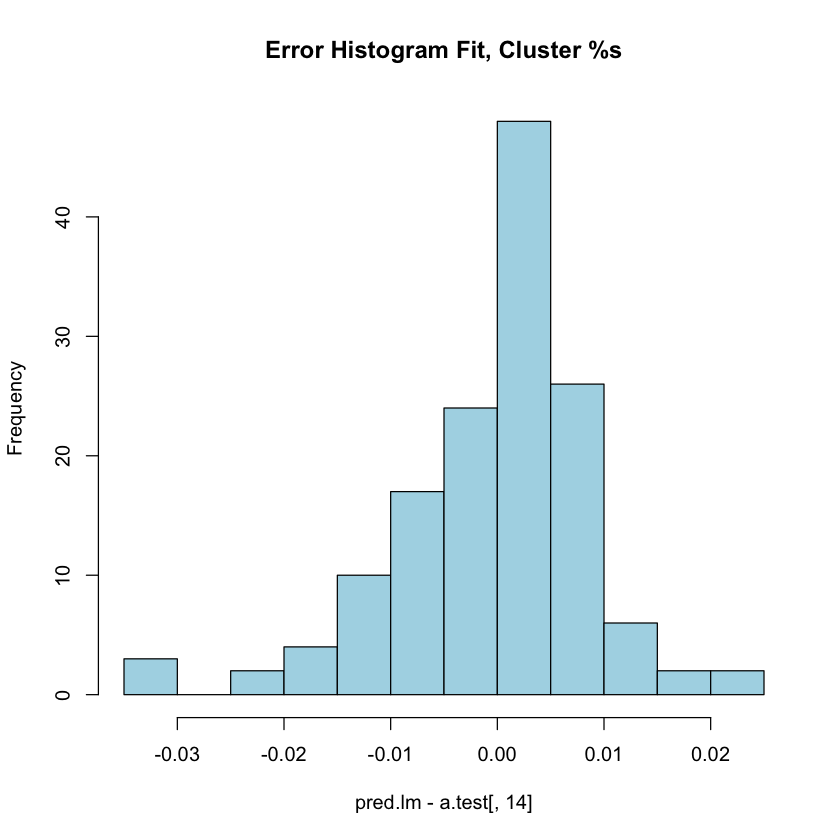

                  ME       RMSE         MAE        MPE     MAPE
Test set 0.001556902 0.01287817 0.007847149 -0.3060929 5.149136


Warning message in temp[2] <- a.rf:
“被替换的项目不是替换值长度的倍数”

[1] 1
[1] "************ Neural Network ************"
SNNS network definition file V1.4-3D
generated at Sun Nov 19 13:58:40 2017

network name : RSNNS_untitled
source files :
no. of units : 31
no. of connections : 240
no. of unit types : 0
no. of site types : 0


learning function : Std_Backpropagation
update function   : Topological_Order


unit default section :

act      | bias     | st | subnet | layer | act func     | out func
---------|----------|----|--------|-------|--------------|-------------
 0.00000 |  0.00000 | i  |      0 |     1 | Act_Logistic | Out_Identity 
---------|----------|----|--------|-------|--------------|-------------


unit definition section :

no. | typeName | unitName                  | act      | bias     | st | position | act func     | out func | sites
----|----------|---------------------------|----------|----------|----|----------|--------------|----------|-------
  1 |          | Input_annual_inc          | 110000.00000 | -0.28936 | i  |  1, 0, 0 | A

Warning message in temp[3] <- a.nn:
“被替换的项目不是替换值长度的倍数”

[1] 1
[1] "************ KNN, Cluster ************"
                  ME       RMSE        MAE       MPE     MAPE
Test set 0.004537599 0.05447139 0.04062669 -9.333373 30.64079


Warning message in temp[4] <- a.knn:
“被替换的项目不是替换值长度的倍数”Warning message in model[i] <- temp:
“被替换的项目不是替换值长度的倍数”

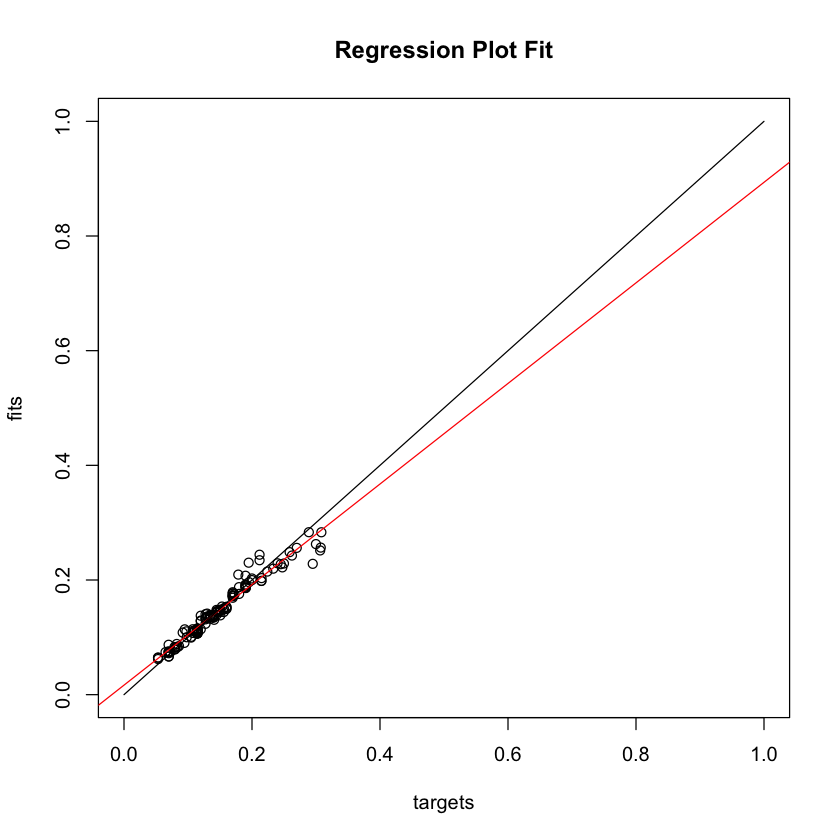

[1] 2
[1] "************ Linear Regression ************"

Call:
lm(formula = f, data = a.train)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0192535 -0.0037744 -0.0009613  0.0031748  0.0272496 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.255e-02  3.012e-03  10.808   <2e-16 ***
annual_inc           1.071e-08  1.183e-08   0.906   0.3659    
dti                  5.586e-06  1.071e-04   0.052   0.9584    
last_pymnt_amnt      1.243e-07  7.986e-08   1.556   0.1208    
mths_since_rcnt_il   7.692e-05  7.461e-05   1.031   0.3035    
all_util             6.068e-05  3.005e-05   2.019   0.0444 *  
total_rev_hi_lim     3.332e-08  2.951e-08   1.129   0.2598    
inq_last_12m         2.289e-04  1.609e-04   1.422   0.1561    
percent_bc_gt_75    -2.008e-05  1.564e-05  -1.284   0.2003    
term                 8.330e-04  1.282e-03   0.650   0.5163    
grade                2.001e-03  1.410e-03   1.420   0.1569    
sub_grade 

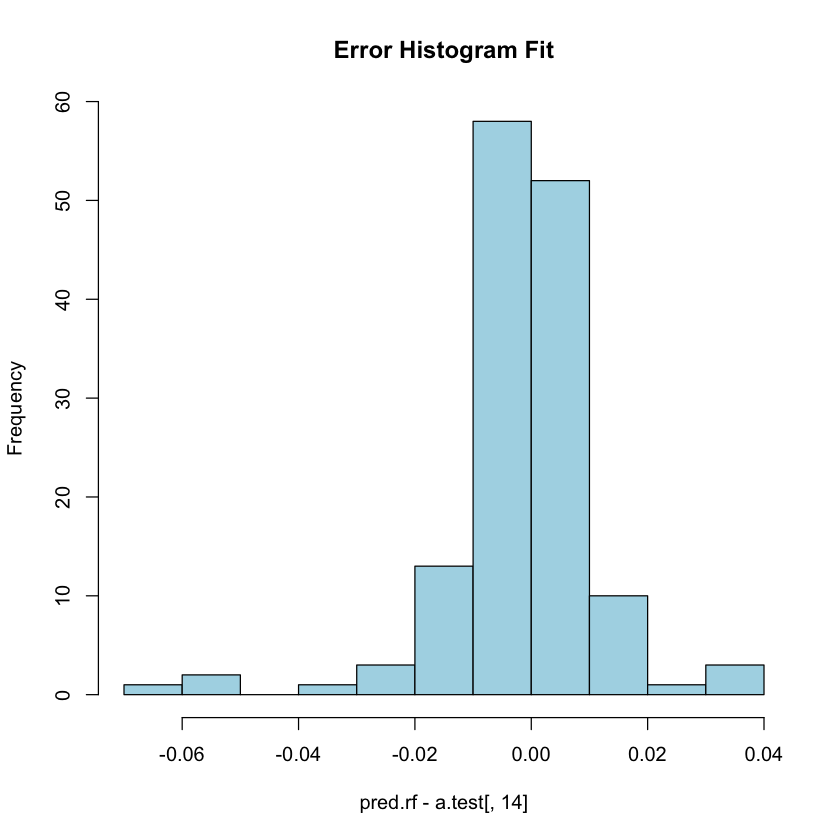

                    ME        RMSE         MAE        MPE     MAPE
Test set -0.0005114802 0.007660675 0.005244381 -0.2043954 4.619527


Warning message in temp[1] <- a.lm:
“被替换的项目不是替换值长度的倍数”

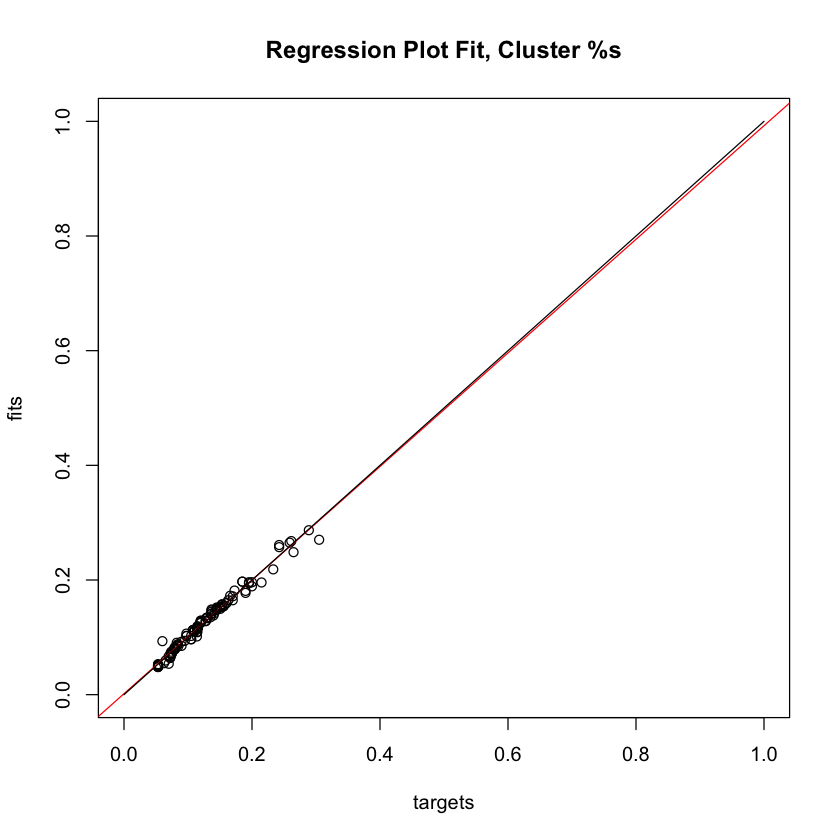

[1] 2
[1] "************ Random Forest ************"


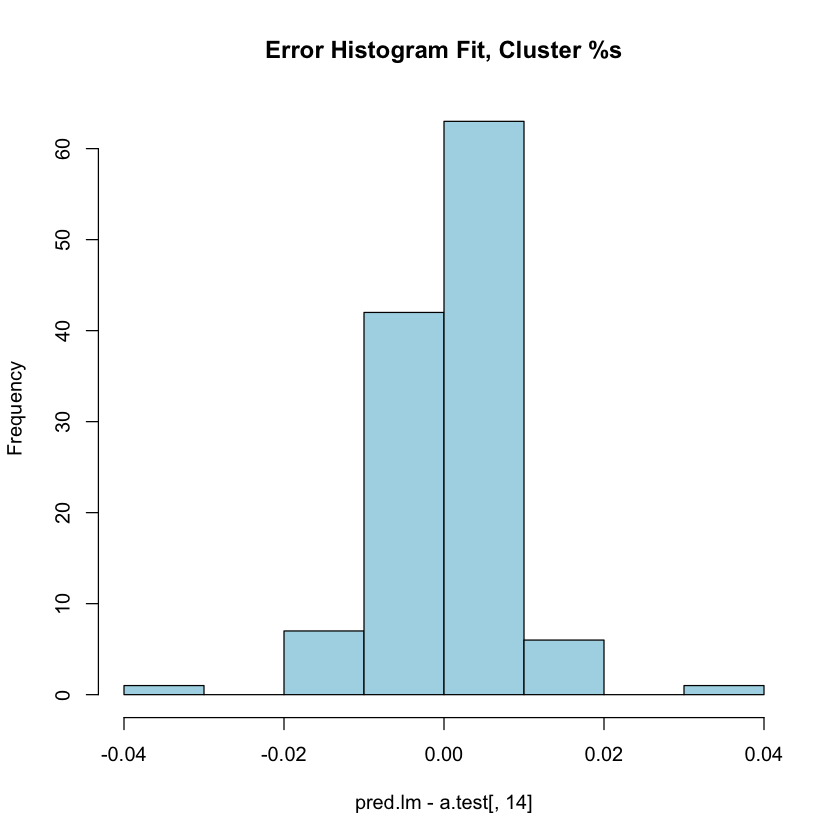

                   ME      RMSE         MAE       MPE     MAPE
Test set 0.0006914213 0.0129449 0.007469494 -1.897179 6.243888


Warning message in temp[2] <- a.rf:
“被替换的项目不是替换值长度的倍数”

[1] 2
[1] "************ Neural Network ************"
SNNS network definition file V1.4-3D
generated at Sun Nov 19 13:58:41 2017

network name : RSNNS_untitled
source files :
no. of units : 31
no. of connections : 240
no. of unit types : 0
no. of site types : 0


learning function : Std_Backpropagation
update function   : Topological_Order


unit default section :

act      | bias     | st | subnet | layer | act func     | out func
---------|----------|----|--------|-------|--------------|-------------
 0.00000 |  0.00000 | i  |      0 |     1 | Act_Logistic | Out_Identity 
---------|----------|----|--------|-------|--------------|-------------


unit definition section :

no. | typeName | unitName                  | act      | bias     | st | position | act func     | out func | sites
----|----------|---------------------------|----------|----------|----|----------|--------------|----------|-------
  1 |          | Input_annual_inc          | 33000.00000 | -0.20968 | i  |  1, 0, 0 | Ac

Warning message in temp[3] <- a.nn:
“被替换的项目不是替换值长度的倍数”

[1] 2
[1] "************ KNN, Cluster ************"
                   ME       RMSE        MAE       MPE     MAPE
Test set -0.001617143 0.05018484 0.03855548 -17.11592 36.09211


Warning message in temp[4] <- a.knn:
“被替换的项目不是替换值长度的倍数”Warning message in model[i] <- temp:
“被替换的项目不是替换值长度的倍数”

[1] 3
[1] "************ Linear Regression ************"

Call:
lm(formula = f, data = a.train)

Residuals:
ALL 13 residuals are 0: no residual degrees of freedom!

Coefficients: (1 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)
(Intercept)          3.111e-01         NA      NA       NA
annual_inc          -3.112e-07         NA      NA       NA
dti                 -9.859e-03         NA      NA       NA
last_pymnt_amnt      5.111e-06         NA      NA       NA
mths_since_rcnt_il   2.919e-03         NA      NA       NA
all_util             1.752e-03         NA      NA       NA
total_rev_hi_lim     1.824e-07         NA      NA       NA
inq_last_12m        -1.071e-02         NA      NA       NA
percent_bc_gt_75    -1.395e-03         NA      NA       NA
term                -1.180e-01         NA      NA       NA
grade               -3.704e-02         NA      NA       NA
sub_grade            3.358e-02         NA      NA       NA
verification_s

Warning message in predict.lm(a.lm, a.test):
“prediction from a rank-deficient fit may be misleading”

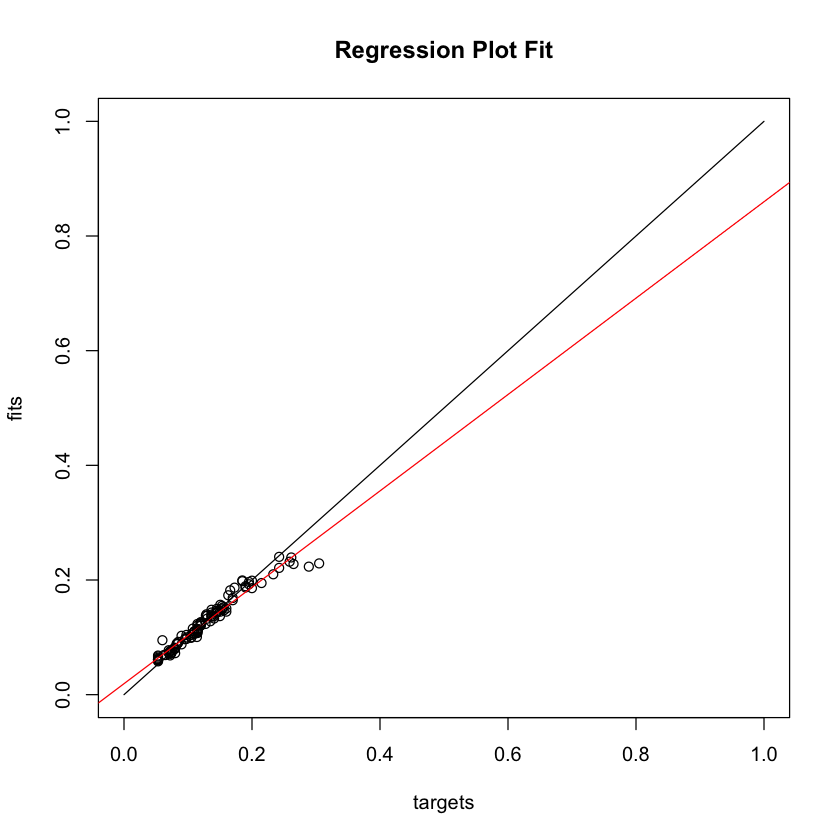

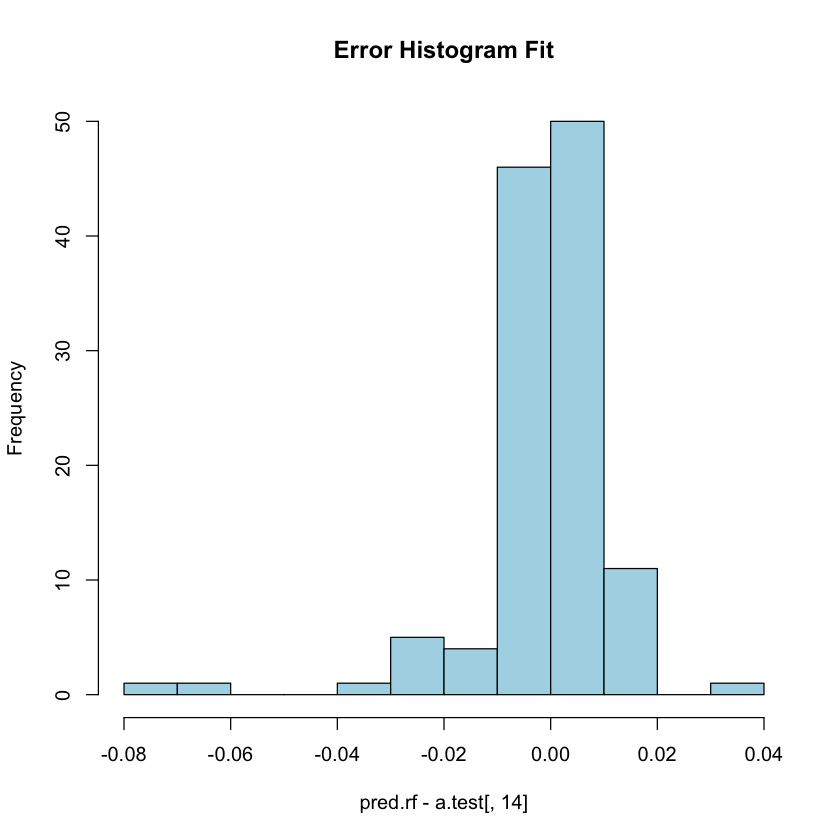

                 ME      RMSE       MAE        MPE    MAPE
Test set -0.0237578 0.1495097 0.1349404 -0.8347755 72.1284


Warning message in temp[1] <- a.lm:
“被替换的项目不是替换值长度的倍数”

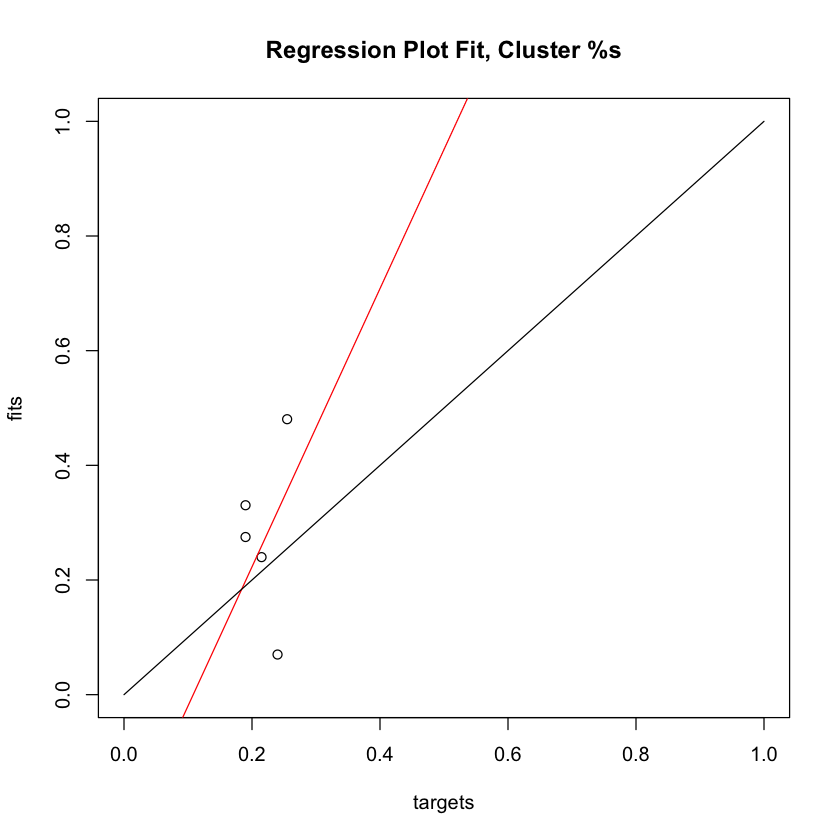

[1] 3
[1] "************ Random Forest ************"


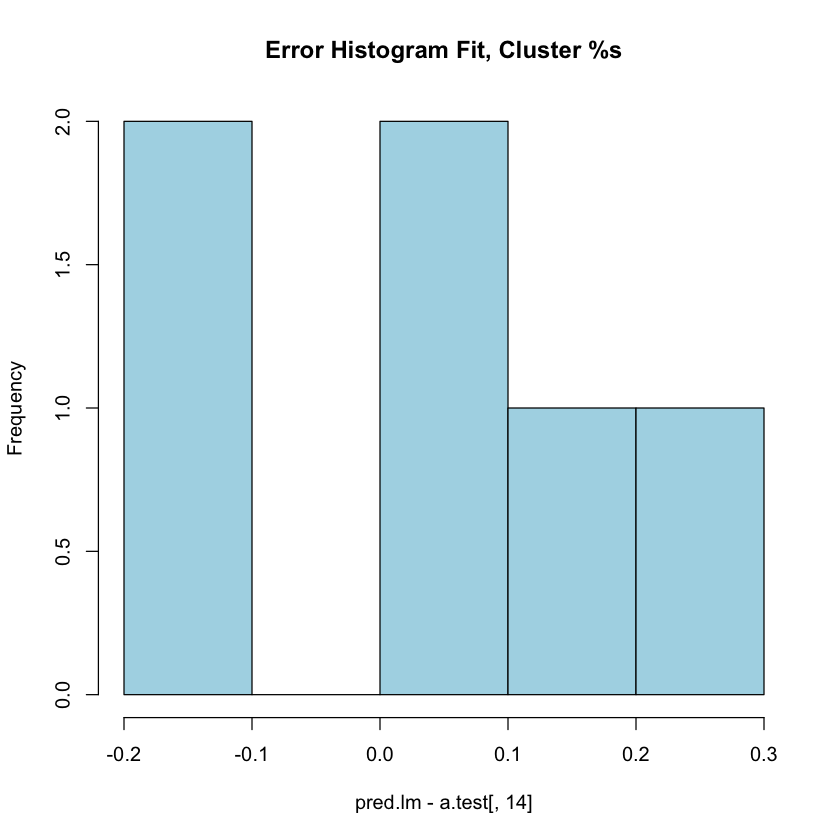

                 ME       RMSE        MAE      MPE     MAPE
Test set 0.01902052 0.02718419 0.02241556 7.725546 10.69324


Warning message in temp[2] <- a.rf:
“被替换的项目不是替换值长度的倍数”

[1] 3
[1] "************ Neural Network ************"
SNNS network definition file V1.4-3D
generated at Sun Nov 19 13:58:41 2017

network name : RSNNS_untitled
source files :
no. of units : 31
no. of connections : 240
no. of unit types : 0
no. of site types : 0


learning function : Std_Backpropagation
update function   : Topological_Order


unit default section :

act      | bias     | st | subnet | layer | act func     | out func
---------|----------|----|--------|-------|--------------|-------------
 0.00000 |  0.00000 | i  |      0 |     1 | Act_Logistic | Out_Identity 
---------|----------|----|--------|-------|--------------|-------------


unit definition section :

no. | typeName | unitName                  | act      | bias     | st | position | act func     | out func | sites
----|----------|---------------------------|----------|----------|----|----------|--------------|----------|-------
  1 |          | Input_annual_inc          | 90000.00000 |  0.23481 | i  |  1, 0, 0 | Ac

Warning message in temp[3] <- a.nn:
“被替换的项目不是替换值长度的倍数”

[1] 3
[1] "************ KNN, Cluster ************"
                 ME       RMSE       MAE      MPE     MAPE
Test set 0.03850476 0.06194299 0.0592381 12.84523 30.96877


Warning message in temp[4] <- a.knn:
“被替换的项目不是替换值长度的倍数”Warning message in model[i] <- temp:
“被替换的项目不是替换值长度的倍数”

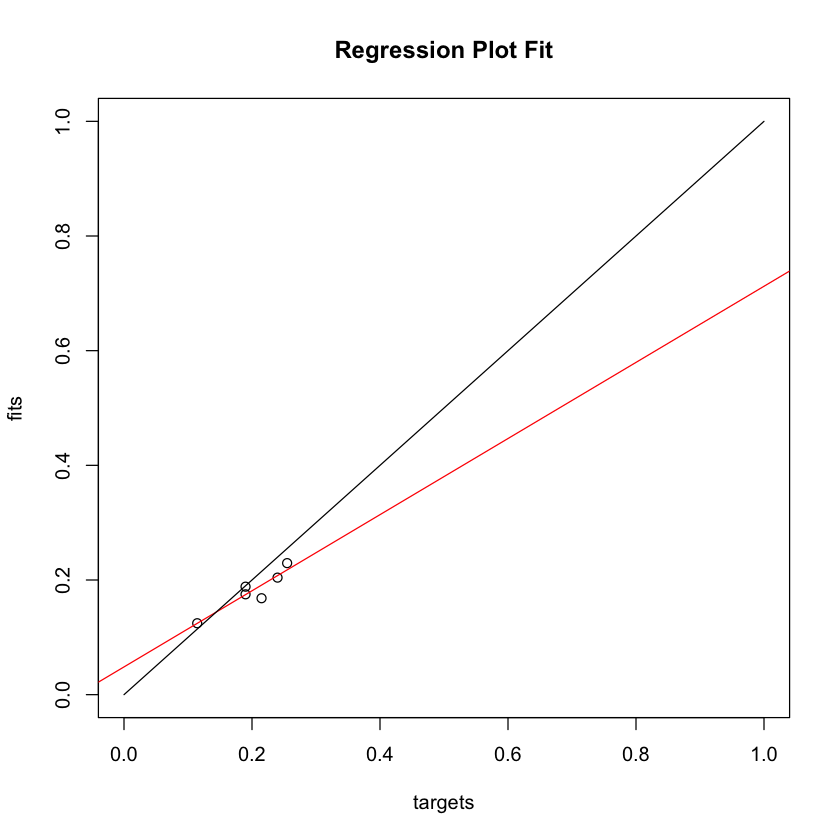

[1] 4
[1] "************ Linear Regression ************"

Call:
lm(formula = f, data = a.train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.021977 -0.003903 -0.000863  0.002627  0.039369 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          4.416e-02  1.620e-03  27.256  < 2e-16 ***
annual_inc          -5.719e-09  5.469e-09  -1.046 0.295974    
dti                  8.221e-06  5.363e-05   0.153 0.878199    
last_pymnt_amnt     -1.410e-07  2.253e-07  -0.626 0.531722    
mths_since_rcnt_il  -6.968e-06  3.579e-05  -0.195 0.845691    
all_util            -5.162e-05  1.451e-05  -3.558 0.000392 ***
total_rev_hi_lim     3.644e-08  1.533e-08   2.377 0.017635 *  
inq_last_12m        -2.658e-05  8.773e-05  -0.303 0.761982    
percent_bc_gt_75    -1.296e-05  8.274e-06  -1.566 0.117567    
term                -9.421e-04  6.570e-04  -1.434 0.151905    
grade                2.747e-03  7.036e-04   3.904 0.000101 ***
sub_grade           

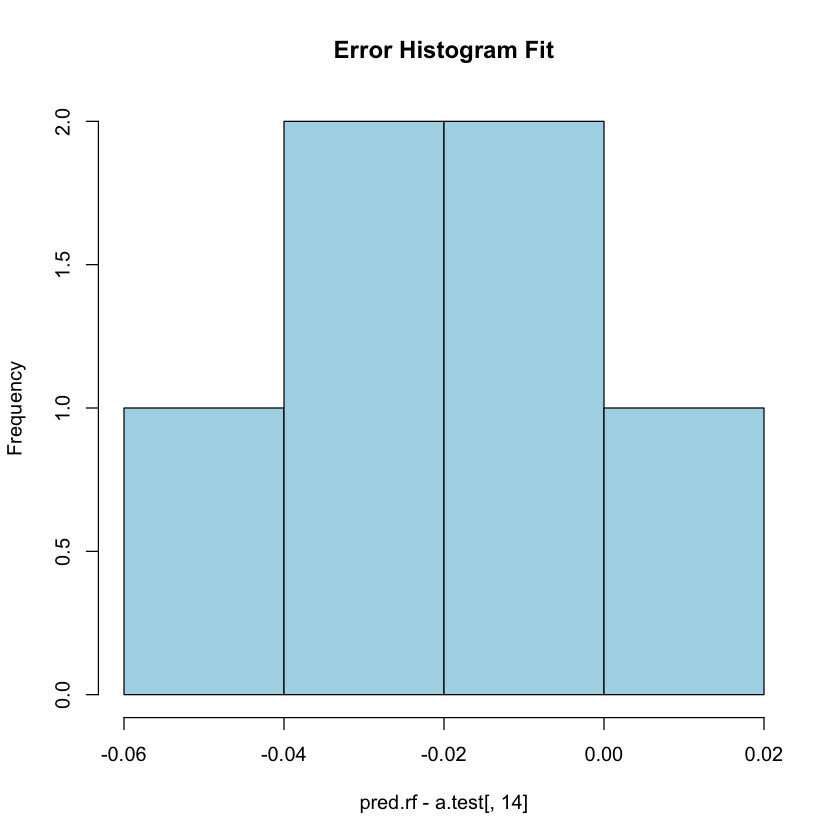

                   ME        RMSE         MAE       MPE     MAPE
Test set 0.0003904654 0.006351744 0.004720678 0.3738729 4.194025


Warning message in temp[1] <- a.lm:
“被替换的项目不是替换值长度的倍数”

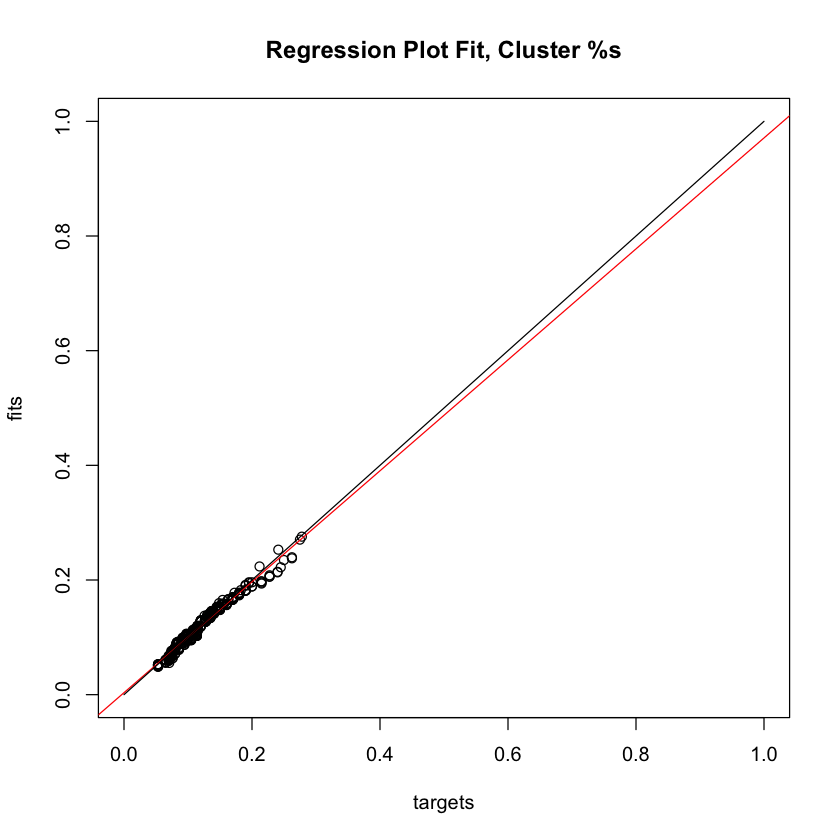

[1] 4
[1] "************ Random Forest ************"


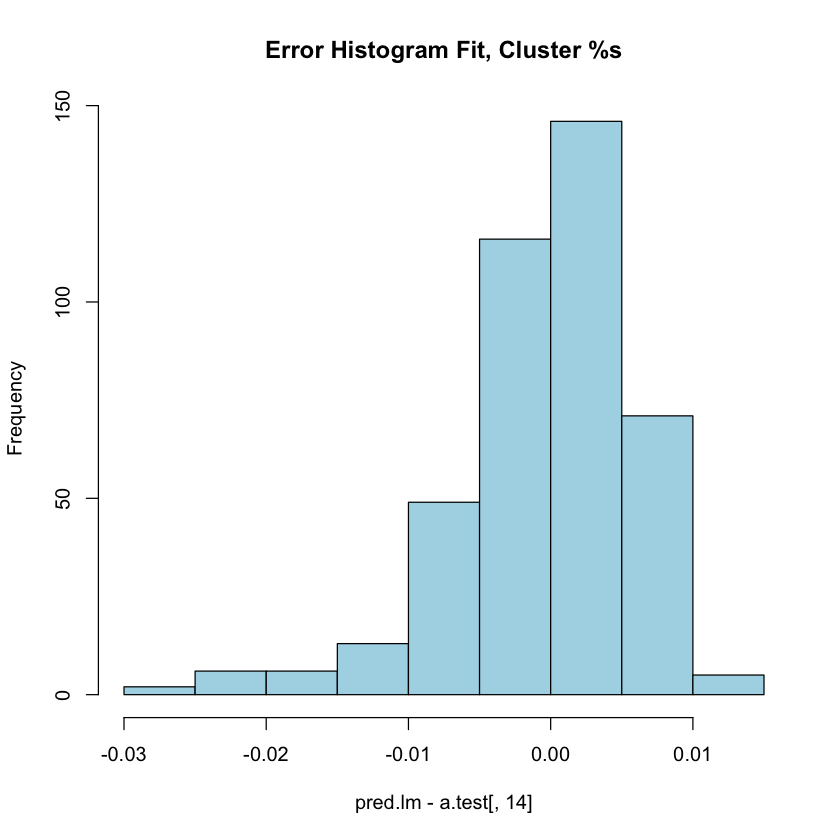

                   ME        RMSE         MAE        MPE     MAPE
Test set 0.0004082271 0.007122578 0.004749751 -0.4342873 4.126768


Warning message in temp[2] <- a.rf:
“被替换的项目不是替换值长度的倍数”

[1] 4
[1] "************ Neural Network ************"
SNNS network definition file V1.4-3D
generated at Sun Nov 19 13:58:43 2017

network name : RSNNS_untitled
source files :
no. of units : 31
no. of connections : 240
no. of unit types : 0
no. of site types : 0


learning function : Std_Backpropagation
update function   : Topological_Order


unit default section :

act      | bias     | st | subnet | layer | act func     | out func
---------|----------|----|--------|-------|--------------|-------------
 0.00000 |  0.00000 | i  |      0 |     1 | Act_Logistic | Out_Identity 
---------|----------|----|--------|-------|--------------|-------------


unit definition section :

no. | typeName | unitName                  | act      | bias     | st | position | act func     | out func | sites
----|----------|---------------------------|----------|----------|----|----------|--------------|----------|-------
  1 |          | Input_annual_inc          | 70000.00000 | -0.12352 | i  |  1, 0, 0 | Ac

Warning message in temp[3] <- a.nn:
“被替换的项目不是替换值长度的倍数”

[1] 4
[1] "************ KNN, Cluster ************"
                   ME       RMSE        MAE       MPE     MAPE
Test set -0.001018634 0.04402254 0.03422043 -12.13862 31.73054


Warning message in temp[4] <- a.knn:
“被替换的项目不是替换值长度的倍数”Warning message in model[i] <- temp:
“被替换的项目不是替换值长度的倍数”

[1] 5
[1] "************ Linear Regression ************"


ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): 0 (non-NA) cases


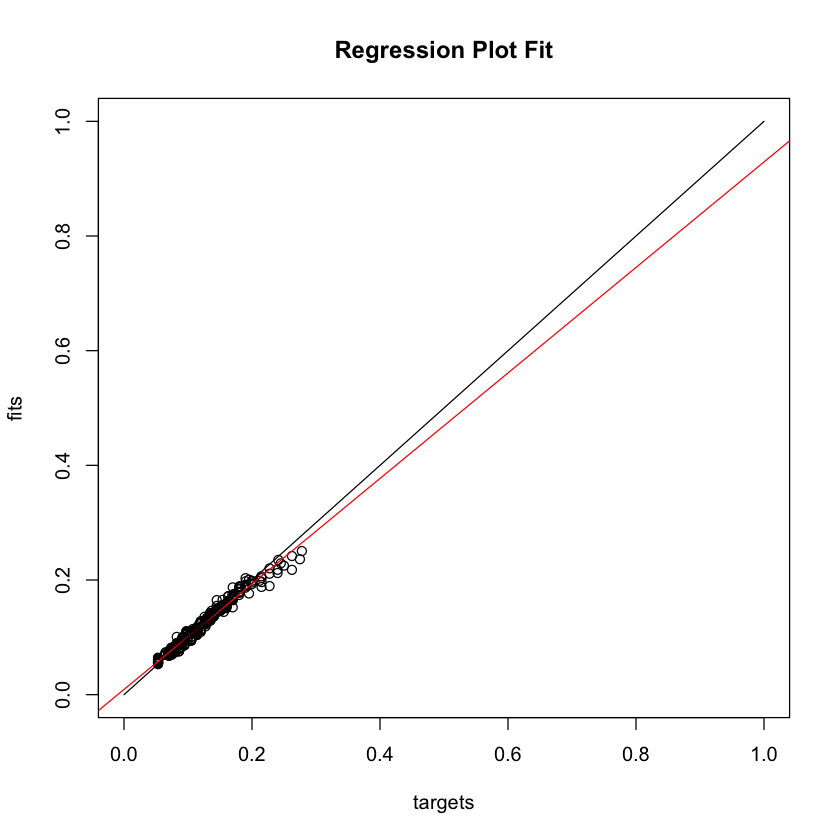

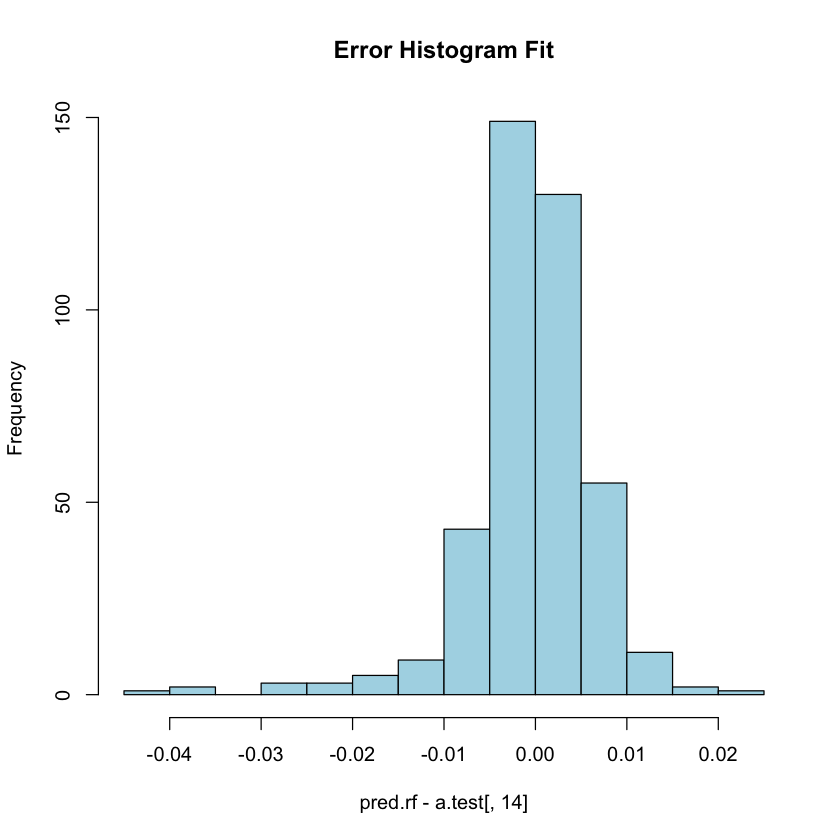

In [61]:
model <- NULL
cluster <- c(1:7)

for (i in cluster){
    
    temp <- NULL
        
    a <- x[x$V81 == i,]
    set.seed(i)
    train<-sample(1:nrow(a),round(nrow(a)*7/10))
    a.train <- a[train,-15]
    a.test <- a[-train,-15]
    
    ### Linear regression ###
    print(i)
    print("************ Linear Regression ************")
    a.lm <- lm(f,data=a.train)
    print(summary(a.lm))

    # Prediction
    pred.lm <- predict(a.lm,a.test)
    
    # Plot
    plotRegressionError(a.test[,14], pred.lm, main="Regression Plot Fit, Cluster %s" )
    hist(pred.lm-a.test[,14], col="lightblue", main="Error Histogram Fit, Cluster %s" )

    # Metrics
    print(accuracy(pred.lm, a.test[,14]))

    # Save the model
    temp[1] <- a.lm


    ### Random forest ###
    print(i)
    print("************ Random Forest ************")
    a.rf <- randomForest(f, data=a.train, ntree=15, importance=TRUE)
    summary(a.rf)

    # Prediction
    pred.rf <- predict(a.rf,a.test)

    # Plot
    plotRegressionError(a.test[,14], pred.rf, main="Regression Plot Fit")
    hist(pred.rf-a.test[,14], col="lightblue", main="Error Histogram Fit")

    # Metrics
    print(accuracy(pred.rf, a.test[,14]))
    
    # Save
    temp[2] <- a.rf

    
    ### Neural network ###
    print(i)
    print("************ Neural Network ************")    
    a.nn <- mlp(a.train,a.train[,14], size=16, maa_iter=200)
    summary(a.nn)
    
    # Prediction
    pred.nn <- predict(a.nn, a.test)
    
    # Save 
    temp[3] <- a.nn

    
    ### KNN ###
    print(i)
    print("************ KNN, Cluster ************")
    a.knn <- knn.reg(train=a.train[,-14], test=a.test[,-14], y=a.train[,14], k=10)
    summary(a.knn)
    
    # Metrics
    print(accuracy(a.knn$pred, a.test[,14]))
    
    # Save 
    temp[4] <- a.knn
    
    
    model[i] <- temp

}